I am attempting to classify and name Humpback whales by picture of their flukes. I got the dataset from Kaggle which is currently organizing the Humpback Whale Identification Challenge.

For creating the models, I used the tutorials from Fast.AI. After creating the intial basic model, I used oversampling to balance the samples as some samples were in large numbers compared to others.

In brief, the results were not satisfactory. My initial model that I directly trained with some data augmentation, only gave a model accuracy of 50% which is extremely low as equal to chance of randomly guessing a coin flip, although greater than from a random guess which would be equal to 1/5005 (number of classes). 

Then, I oversampled my dataset because there were many images which had only one samples whereas some had more to balance my dataset. However, it increased the size of my dataset highly and took extremely long time. So, I had to stop my training midway. However, I believe with longer training over this dataset, the model should be able to classify data properly.

I used accuracy as the main metrics for measuring performance of the classification because it tells us how accurately or how well the data can classify each data point to a correct class. 

In [3]:
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
import pandas as pd

from utils import *

In [2]:
# Loading the labels
df = pd.read_csv('data/train.csv')
df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [3]:
df.Id.value_counts().head()

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

In [4]:
(df.Id == 'new_whale').mean()

0.3810575292772367

In [5]:
(df.Id.value_counts() == 1).mean()

0.4141858141858142

As displayed aboved 38% of all images are new whale image. 41% of all known whales images have only a single image associated with them. Due to this disparity, new_whale images have more variety, which may not even be overcame by data augmentation.

In [25]:
df.Id.nunique()

5005

In [7]:
df.shape

(25361, 2)

In [8]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}

In [9]:
SZ = 224
BS = 64
NUM_WORKERS = 12
SEED=0

In [10]:
data = (
    ImageItemList
        .from_folder('data/train')
        .random_split_by_pct(seed=SEED)
        .label_from_func(lambda path: fn2label[path.name])
        .add_test(ImageItemList.from_folder('data/test'))
        .transform(get_transforms(do_flip=False, max_zoom=1, max_warp=0, max_rotate=2), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
)
# transform performs data augmentation.
# It randomly picks and rotates the images by 2 degrees.
# Adding more augementation may be even more helpful.

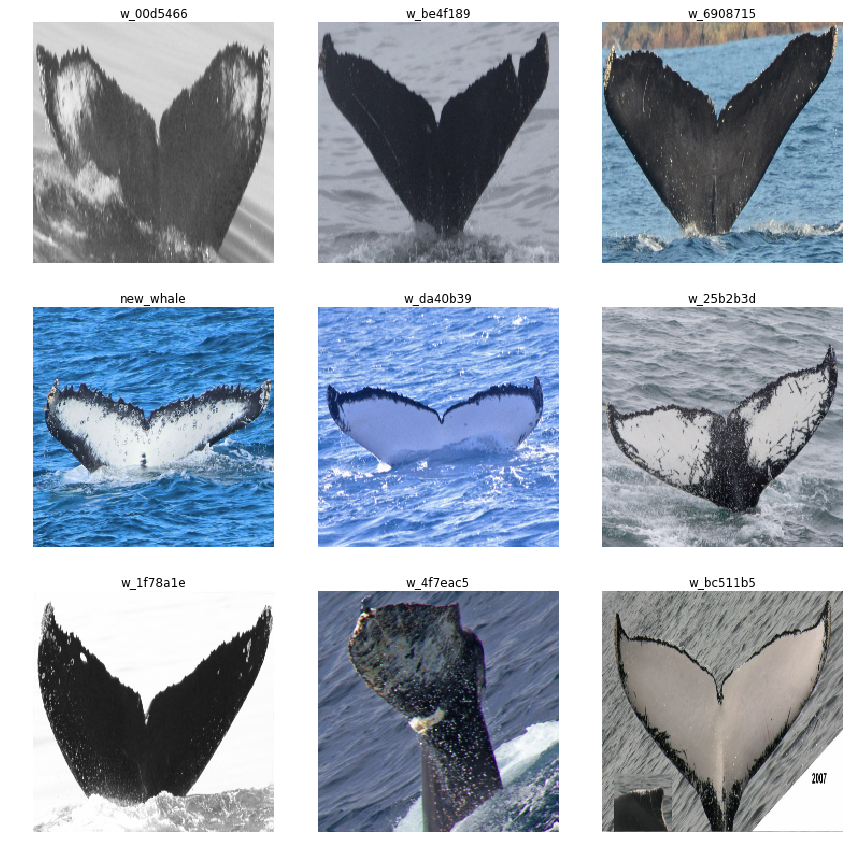

In [11]:
data.show_batch(rows=3)

## Training model

In [12]:
name = f'res50-{SZ}'

I used ResNet instead of other traditional CNNs like VGG because, it is faster to train and had given better result even with less complexity complexity.
Compared to VGG-16 model which has roughly 138 million parameters, ResNet only has 25.5 million parameters, which makes it a lot smaller than the traditional CNN like VGG-16.
On top of that instead of straight combination of convolution layer after layer like VGG-16, Resnet alrenately stacks convolutional operation with on-linear activation functions, to make it thinner.
On top of that, the identity of the residual network also learns the residue of input and output of some layers, as the input of a higher layer and fed into a deeper layer. So, instead of activation being H(x) = F(x) for a traditional CNN, in some layers activation function will be H(x) = F(x) + x.


In [13]:
# Compinling a CNN model. The model will fine-tune pre-trained
# ResNet50 CNN. We are using accuracy as our metrics.
cnn = create_cnn(data, models.resnet50, metrics=[accuracy, map5])

In [15]:
# Fitting the CNN model with for 2 epochs.
# With only 2 epochs we are able to get 50% accuracy.
cnn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,map5
1,5.787032,4.367648,0.493691,0.518300
2,4.922387,4.142657,0.505718,0.537119


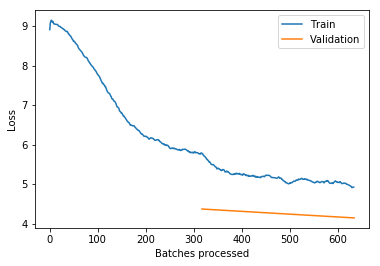

In [16]:
cnn.recorder.plot_losses()

The ammount of training losses falls rapidly after processing 300 baches. Similarly the validation loss is also decreasing. The minimum loss of current model is 4.9.

In [17]:
cnn.save(f'{name}-stage-1')

In [18]:
cnn.unfreeze()

In [19]:
# FastAI's library has function to find the best learning rate by running
# test on few epochs, by increasing the learning rate with small batches.
cnn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


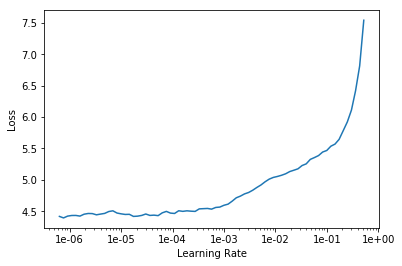

In [20]:
cnn.recorder.plot()

Based on the plot above, using learning rate as 1e-4 or lower gives us the least loss. And, as our learning rate increases, our loss starts to increases exponentially. So, I am fixing our maximum learning rate to 1e-4.

In [21]:
max_lr = 1e-4
lrs = [max_lr/100, max_lr/10, max_lr]

In [22]:
# Using a cyclic policy of learning that changes learning rate from
# upper bound to lower bound, and makes it smaller as we are converging.
# The higher bound learning rate allows us to move far and find saddle 
# point if possible.
cnn.fit_one_cycle(5, lrs)

epoch,train_loss,valid_loss,accuracy,map5
1,4.586086,4.119736,0.508281,0.541019
2,4.451940,4.054281,0.515970,0.549116
3,4.298927,3.993938,0.516759,0.553772
4,4.103948,3.978109,0.518139,0.555060
5,4.034631,3.980265,0.517350,0.554748


## Results
The model only achieves an accuracy of 0.52 which is not an great result. It is only correctly classifying any image correctly only 50% of the time, which is equal to random chance.
The poor performance of the model is probably due to over sampling of new_whale data and abundance of whale images that have only one copy in the dataset, that simply adds up new number of classes with minimal details. 
I will perform oversampling to increase the dataset to check if we could improve.

In [26]:
cnn.save(f'{name}-stage-2')

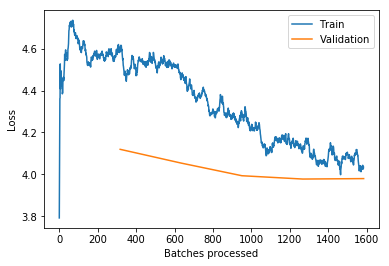

In [27]:
cnn.recorder.plot_losses()

## Prediction

The following code creates results in required format to be submitted to Kaaggle competition

In [28]:
preds, _ = cnn.get_preds(DatasetType.Test)

In [36]:
preds[0].max()

tensor(0.1614)

In [30]:
mkdir -p subs

In [31]:
create_submission(preds, cnn.data, name)

In [32]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,Image,Id
0,68f340d0c.jpg,w_bc285a6 w_0bc078c w_51fc1fc w_3de579a w_57aeea3
1,e630231e9.jpg,w_fd3e556 new_whale w_60cf87c w_60ce6fc w_3879fa0
2,ede743c5f.jpg,new_whale w_e906edd w_fd3e556 w_9da1811 w_5e8e218
3,23877c73f.jpg,new_whale w_d405854 w_2365d55 w_eba33fb w_f765256
4,ad3afe7cb.jpg,new_whale w_e2a09d4 w_08d62ee w_8cfabed w_69c06ad


In [33]:
!kaggle competitions submit -c humpback-whale-identification -f subs/{name}.csv.gz -m "{name}"

100%|█████████████████████████████████████████| 126K/126K [00:01<00:00, 102KB/s]
Successfully submitted to Humpback Whale Identification

# Oversampling

To overcome the effect of undersampling due to imbalance of samples in the data, I sampled every data. I increased the number of samples to 15 for data points with less than 15 samples and decreases the number of samples to 15 for data points with more than 15 samples.

In [51]:
SZ = 224 * 2
BS = 64 // 4
NUM_WORKERS = 12
SEED=0
import re 
import pandas as pd

In [63]:
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [72]:
df_train = pd.read_csv('data/train.csv')

def over_sample(df_train, num_samples = 15):
    # Only increasing the numbers of sample of pictures have a name
    df_no_whale = df_train[df_train.Id != 'new_whale']

    df_over_sample = None
    sample_to = num_samples

    for grp in df_no_whale.groupby('Id'):
        # finding the number of sample of each label
        n = grp[1].shape[0]
        # increasing number of samples to 15 if they are less
        # decreasing the number if they are more than 15
        additional_rows = grp[1].sample(0 if sample_to < n  else sample_to - n, replace=True)
        rows = pd.concat((grp[1], additional_rows))

        #
        if df_over_sample is None: 
            df_over_sample = rows
        else: 
            df_over_sample= pd.concat((df_over_sample, rows))

    return(df_over_sample)

In [73]:
df_over_sample = over_sample(df_train)
print(df_over_sample.shape)

print(df_train.shape)

# Combining new_whales samples to the over_samples dataset
new_whales = df_train[df_train.Id == 'new_whale']
df_combined = pd.concat([df_over_sample, new_whales])
df_combined.shape

(76287, 2)
(25361, 2)


(85951, 2)

In [74]:
data = (
    ImageItemList
        .from_df(df_combined, 'data/train', cols=['Image'])
        .random_split_by_pct(seed=SEED)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder('data/test'))
        .transform(get_transforms(do_flip=False, max_zoom=1, max_warp=0, max_rotate=10), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)


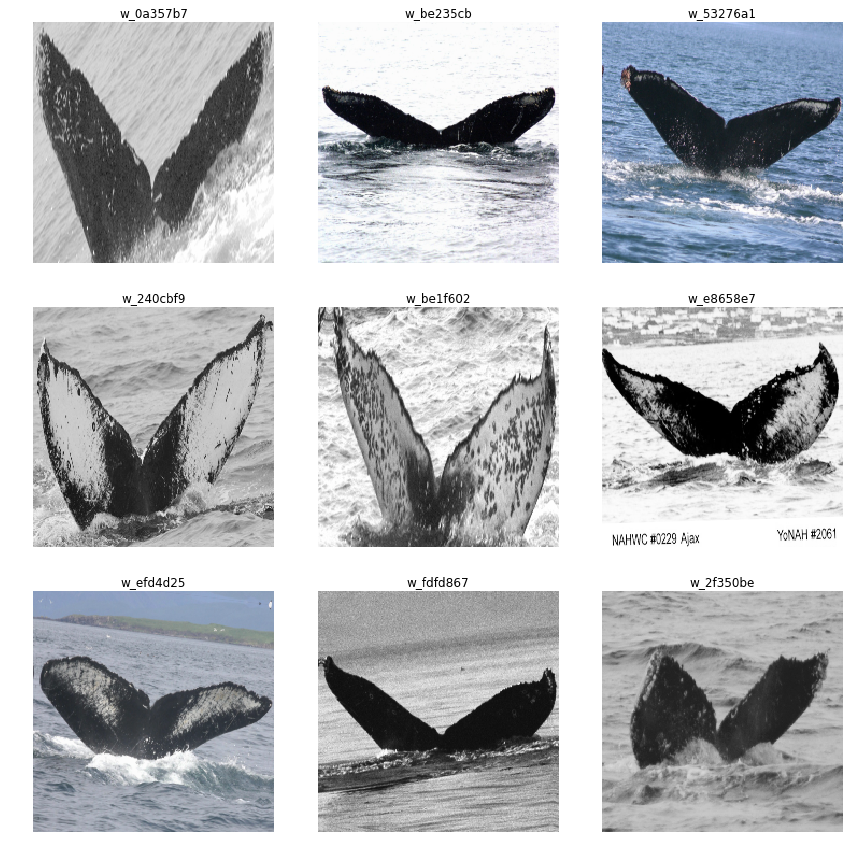

In [75]:
data.show_batch(rows=3)

In [85]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (63284 items)
[Category w_0003639, Category w_0003639, Category w_0003639, Category w_0003639, Category w_0003639]...
Path: data/train
x: ImageItemList (63284 items)
[Image (3, 700, 1050), Image (3, 700, 1050), Image (3, 700, 1050), Image (3, 700, 1050), Image (3, 700, 1050)]...
Path: data/train;

Valid: LabelList
y: CategoryList (15821 items)
[Category w_e4b4611, Category w_60122fa, Category w_454f511, Category w_5c2c1a1, Category w_c67271f]...
Path: data/train
x: ImageItemList (15821 items)
[Image (3, 700, 1050), Image (3, 700, 1050), Image (3, 404, 1050), Image (3, 600, 1050), Image (3, 525, 1050)]...
Path: data/train;

Test: LabelList
y: CategoryList (7960 items)
[Category w_0003639, Category w_0003639, Category w_0003639, Category w_0003639, Category w_0003639]...
Path: data/train
x: ImageItemList (7960 items)
[Image (3, 321, 562), Image (3, 333, 1050), Image (3, 600, 1050), Image (3, 372, 1050), Image (3, 405, 630)]...
Path: data/

epoch,train_loss,valid_loss,accuracy,map5
1,5.922947,5.006917,0.333450,0.413148
2,5.349367,4.590652,0.336766,0.504068


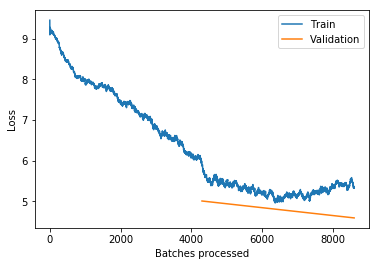

In [90]:
name = f'res50-{SZ}'

cnn = create_cnn(data, models.resnet50, metrics=[accuracy, map5])

cnn.fit_one_cycle(2)

cnn.recorder.plot_losses()

As shown, above, the initial performance of the model dropped, but I assume it will be increasing gradually as we train it through multiple epoch. In the lack of time and computational power, it will take hours to train this dataset, so I am currently stopping it. 


In [ ]:
# Finding the best learning rate

cnn.lr_find()
cnn.recorder.plot()

In [ ]:
max_lr = 1e-4 
lrs = [max_lr/100, max_lr/10, max_lr]

# Hope to run for hours in future with 10 epochs as below
cnn.fit_one_cycle(10, lrs)

## Next Steps
Furthermore, I have combined all the images with 'new_whale' label in the same dataset. Given more time, I would separate these images, and train my model. And, create somewhat like a binary classifier, which would predict an image as 'new_whale' only if output values for all the classes are under a certain threshold.